# Classical Portfolio Optimization (Modern Portfolio Theory)

We implement Markowitz MPT to find:
- **Minimum Volatility Portfolio** (safest allocation)
- **Maximum Sharpe Ratio Portfolio** (best risk-adjusted return / Sharpe)

This is our baseline before testing ML-based allocations.


We then extend with:
- **Practical constraint:** cap any asset ≤ 30% to avoid unrealistic concentration.
- **Stability metrics:** Effective Number of Assets (N_eff) to measure diversification.

This shows both the strengths and weaknesses of classical MPT, setting up why ML might improve things later.

## 1. Optimizer Setup

We define the expected returns (μ) and covariance (Σ) from the values we got during EDA.

The risk-free rate is set at 2% by defauly for the Sharpe ratio calculations.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

RISK_FREE = 0.02

mu_annual = pd.read_csv("../data/annualized_mean_returns.csv", index_col=0).squeeze("columns")
cov_annual = pd.read_csv("../data/annualized_cov_matrix.csv", index_col=0)

if isinstance(mu_annual, pd.DataFrame):
    mu_annual = mu_annual.iloc[:, 0]


tickers = mu_annual.index.tolist()
mu = mu_annual.values
cov = cov_annual.values

display(mu_annual.to_frame("mu").T)
print("Cov shape: ", cov_annual.shape)



,AAPL,MSFT,AMZN,META,NVDA,SPY,TLT,GLD
mu,0.324056,0.327716,0.263843,0.313301,0.817466,0.161039,-0.008714,0.14672


Cov shape:  (8, 8)


## 2. Portfolio Metrics

I defined functions to calculate:
- Expected return (μᵀw): weighted average of asset returns 
- Volatility (√(wᵀΣw)): overall portfolio risk based on the covariance matrix
- Sharpe ratio ((Rp – Rf)/σp): excess return per unit of volatility

In [5]:
def portfolio_return(weights, mu_vec):
    return float(np.dot(weights, mu_vec))

def portfolio_vol(weights, cov_mat):
    return float(np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights))))

def sharpe_ratio(weights, mu_vec, cov_mat, risk_free=0.02):
    ret = portfolio_return(weights, mu_vec)
    vol = portfolio_vol(weights, cov_mat)
    return (ret - risk_free) / vol if vol > 0 else -np.inf

## 3. Optimization Routine

Now, we need to set up the optimization problem with two constraints (explained in report/decisions.md):

- Weights >= 0 (long-only, no shorting)
- Sum (weights) = 1 (fully invested portfolio)

Then, we solve for:
- Minimum Volatility Portfolio
- Maximum Sharpe Ratio Portfolio



In [6]:
def optimize_portfolios(mu_vec, cov_mat, risk_free = 0.02):
    n = len(mu_vec)
    w0 = np.ones(n) / n
    bounds = [(0.0, 1.0)] * n
    cons = {'type' : 'eq', 'fun' : lambda w: np.sum(w) - 1.0}

    res_min_vol = minimize(lambda w: portfolio_vol(w, cov_mat), w0, bounds=bounds, constraints=cons)
    w_min_vol = res_min_vol.x

    res_max_sharpe = minimize(lambda w: -sharpe_ratio(w, mu_vec, cov_mat, risk_free), w0, bounds=bounds, constraints=cons)
    w_max_sharpe = res_max_sharpe.x

    return w_min_vol, w_max_sharpe

## 4. Optimal Allocations

Now we have to compute and display the asset weights for:
- Minimum Volatility Portfolio
- Maximum Sharpe Ratio Portfolio

We also verify the constraints we set:
- Do weights sum to 1?
- Are any weights negative?

In [7]:
w_min_vol, w_max_sharpe = optimize_portfolios(mu, cov, 0.02)

alloc_min_vol = pd.Series(w_min_vol, index=tickers, name='MinVol').sort_values(ascending=False)
alloc_max_sharpe = pd.Series(w_max_sharpe, index=tickers, name="MaxSharpe").sort_values(ascending=False)

display(alloc_min_vol.round(3))
display(alloc_max_sharpe.round(3))

print("Sum to 1?  MinVol:", round(alloc_min_vol.sum(), 6), " | MaxSharpe:", round(alloc_max_sharpe.sum(), 6))
print("Any negative? MinVol:", (alloc_min_vol<0).any(), " | MaxSharpe:", (alloc_max_sharpe<0).any())

TLT     0.379
GLD     0.332
SPY     0.289
MSFT    0.000
AAPL    0.000
AMZN    0.000
META    0.000
NVDA    0.000
Name: MinVol, dtype: float64

GLD     0.629
NVDA    0.335
AAPL    0.036
AMZN    0.000
META    0.000
MSFT    0.000
SPY     0.000
TLT     0.000
Name: MaxSharpe, dtype: float64

Sum to 1?  MinVol: 1.0  | MaxSharpe: 1.0
Any negative? MinVol: False  | MaxSharpe: False


## 5. Portfolio Performance

Here we compare annualized return, volatility, and Sharpe ratio.

In [9]:
perf = pd.DataFrame(
    {
        "Return": [
            portfolio_return(w_min_vol, mu),
            portfolio_return(w_max_sharpe, mu)
        ],
        "Volatility": [
            portfolio_vol(w_min_vol, cov),
            portfolio_vol(w_max_sharpe, cov)
        ],
        "Sharpe": [
            sharpe_ratio(w_min_vol, mu, cov),
            sharpe_ratio(w_max_sharpe, mu, cov)
        ],
    },
    index=["Min Vol", "Max Sharpe"]
)
perf.style.format({"Return": "{:.2%}", "Volatility": "{:.2%}", "Sharpe": "{:.2f}"})


,Return,Volatility,Sharpe
Min Vol,9.19%,10.18%,0.71
Max Sharpe,37.80%,20.81%,1.72


## 6. Allocation Visualization

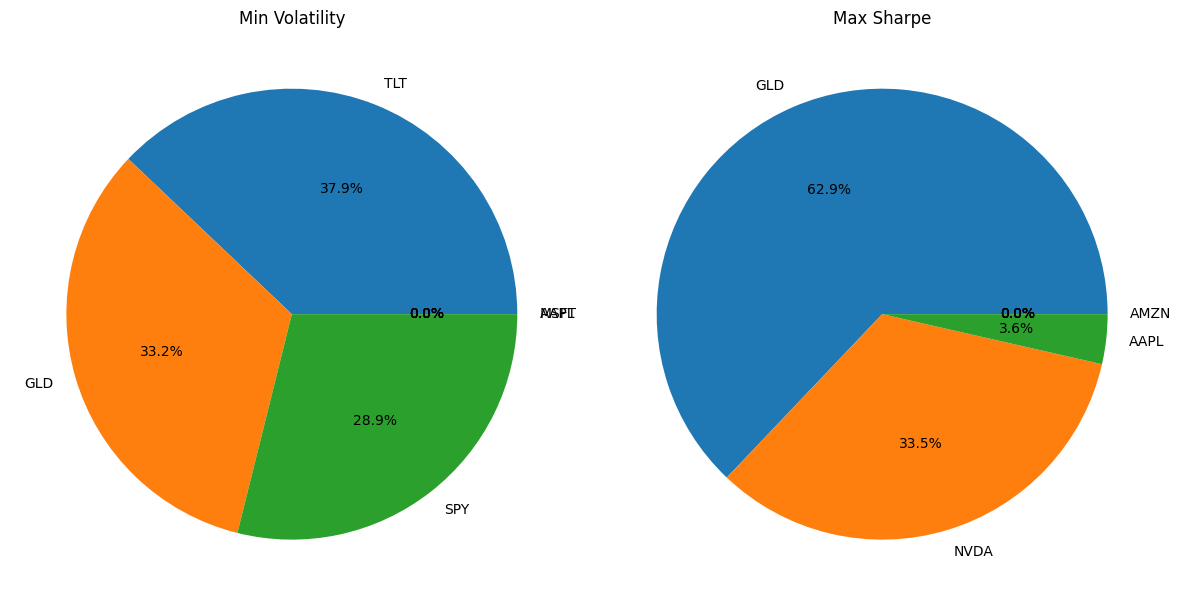

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
alloc_min_vol.plot(kind="pie", ax=axes[0], autopct="%.1f%%", title="Min Volatility", ylabel="")
alloc_max_sharpe.plot(kind="pie", ax=axes[1], autopct="%.1f%%", title="Max Sharpe", ylabel="")
plt.tight_layout()
plt.show()

## 6.1 Practical Constraint: Cap Any Single Asset at 30%

As we can see in the pie charts above, unconstrained MPT often produces *corner solutions* where only a few assets are allocated with high weights. 

In reality, portfolios impose position limits (for example no allocation can exceed 30%)

After adding this new constraint, we can re-run Max-Sharpe with that cap to force diversification. 

NVDA    0.300
GLD     0.300
TLT     0.155
MSFT    0.139
AAPL    0.107
SPY     0.000
AMZN    0.000
META    0.000
Name: MaxSharpe_cap30, dtype: float64

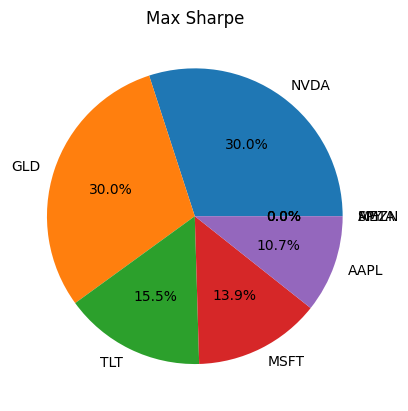

In [17]:
def optimize_with_cap(mu_vec, cov_mat, risk_free=RISK_FREE, cap=0.30):
    n = len(mu_vec)
    w0 = np.ones(n) / n
    bounds = [(0.0, cap)] * n
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
    res = minimize(lambda w: -sharpe_ratio(w, mu_vec, cov_mat, risk_free),
                   w0, bounds=bounds, constraints=cons)
    return res.x

w_max_sharpe_cap30 = optimize_with_cap(mu, cov, cap=0.30)
alloc_max_sharpe_cap30 = pd.Series(w_max_sharpe_cap30, index=tickers, name="MaxSharpe_cap30").sort_values(ascending=False)

display(alloc_max_sharpe_cap30.round(3))
alloc_max_sharpe_cap30.plot(kind="pie", autopct="%.1f%%", title="Max Sharpe", ylabel="")
plt.show()

### Comparison: Unconstrained vs 30% Cap

In [18]:
alloc_compare = pd.concat(
    [alloc_max_sharpe.rename("Unconstrained"),
     alloc_max_sharpe_cap30.rename("Cap30%")],
    axis=1
).fillna(0)

def perf_row(w, name):
    return pd.Series({
        "Return": portfolio_return(w, mu),
        "Volatility": portfolio_vol(w, cov),
        "Sharpe": sharpe_ratio(w, mu, cov)
    }, name=name)

perf_cap = pd.concat([
    perf_row(w_max_sharpe, "Max Sharpe (Unconstrained)"),
    perf_row(w_max_sharpe_cap30, "Max Sharpe (Cap 30%)")
], axis=1).T

display(alloc_compare.round(3))
perf_cap.style.format({"Return":"{:.2%}","Volatility":"{:.2%}","Sharpe":"{:.2f}"})


,Unconstrained,Cap30%
GLD,0.629,0.300
NVDA,0.335,0.300
AAPL,0.036,0.107
AMZN,0.000,0.000
META,0.000,0.000
MSFT,0.000,0.139
SPY,0.000,0.000
TLT,0.000,0.155


,Return,Volatility,Sharpe
Max Sharpe (Unconstrained),37.80%,20.81%,1.72
Max Sharpe (Cap 30%),36.79%,21.57%,1.61


### Visual Comparison

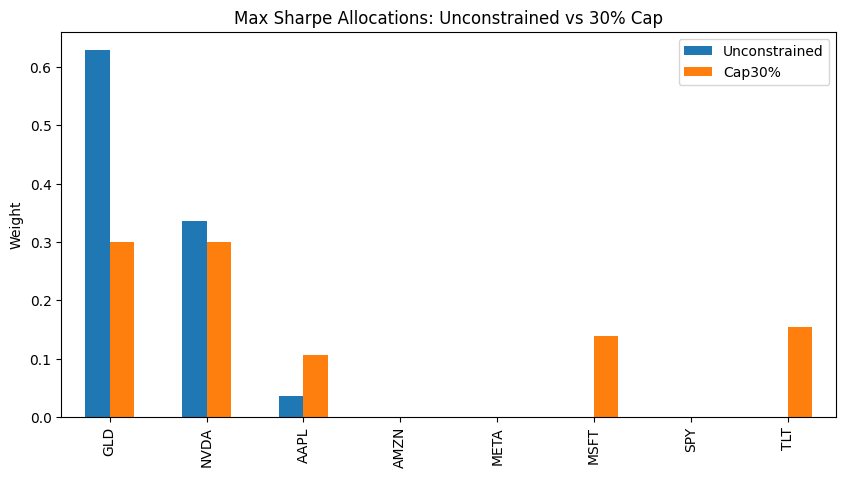

In [19]:
alloc_compare.plot(kind="bar", figsize=(10,5), title="Max Sharpe Allocations: Unconstrained vs 30% Cap")
plt.ylabel("Weight")
plt.show()


## 6.2 Stability Metrics

From the comaprisons in the previous section, we observed that the uncapped portfolio allocation results in a higher Sharpe Ratio. So we should go with that right? Not quite. We can't rely on Sharpe alone as it doesn't measure portfolio stability. In practice, it is always better to have a diversified portfolio. 

Hence why we can add stability metrics such as:
- **Effective Number of Assets (N_eff):** diversification measure  
  $$
  N_\text{eff} = \frac{1}{\sum_i w_i^2}
  $$  

- **Turnover:** how much allocations change at each rebalance (used later in backtests).


In [20]:
def effective_n_assets(weights):
    return 1 / np.sum(weights**2)

n_eff_unconstrained = effective_n_assets(w_max_sharpe)
n_eff_cap30 = effective_n_assets(w_max_sharpe_cap30)

print("Effective Number of Assets (N_eff):")
print("  Unconstrained:", round(n_eff_unconstrained, 2))
print("  Cap 30%:", round(n_eff_cap30, 2))


Effective Number of Assets (N_eff):
  Unconstrained: 1.96
  Cap 30%: 4.26


## 7. Key Insights

- **Unconstrained Max Sharpe**
  - Highest Sharpe (1.72) but concentrated: ~63% GLD + 33% NVDA.
  - N_eff ≈ 2 → effectively a two-asset portfolio.

- **Cap 30% Max Sharpe**
  - More diversified (N_eff higher).
  - Slightly lower Sharpe (1.61) and higher volatility.
  - Reflects real-world trade-off: some efficiency is sacrificed for robustness.

### Why It Matters
- Unconstrained MPT is mathematically optimal but impractical (concentration risk, instability).  
- Constraints produce more implementable portfolios, closer to what real managers use.  
- **Bridge to ML:** Even with constraints, MPT is backward-looking and sensitive to estimation error.  
  Next, we’ll test whether ML forecasts or adaptive methods can improve Sharpe without corner solutions.
